## https://github.com/praxidike97/GraphNeuralNet/blob/master/main.py

In [ ]:

'''
### Basic Template

class MessagePassing(Layer): # Or `Module`

    def call(self, inputs, **kwargs):  # Or `forward`
        # This is the actual message-passing step
        return self.propagate(*inputs)

    def propagate(self, x, a, e, **kwargs):
        # process arguments and create *_kwargs
        ...

        # Message
        messages = self.message(x, **msg_kwargs)

        # Aggregate
        aggregated = self.aggregate(messages, **agg_kwargs)

        # Update
        output = self.update(aggregated, **upd_kwargs)

        return output

    def message(self, x, **kwargs):
        ...

    def aggregate(self, messages, **kwargs):
        ...

    def update(self, aggregated, **kwargs):
        ...
'''

In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

C:\Users\suagrawa\Anaconda3\envs\Optimization-Python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


In [4]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

In [6]:
def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

In [7]:
def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()


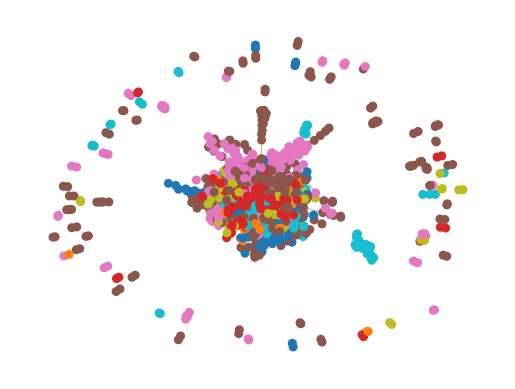

Epoch: 000, Loss: 1.95325, Train Acc: 0.38571, Test Acc: 0.15600
Epoch: 001, Loss: 1.89939, Train Acc: 0.53571, Test Acc: 0.25700
Epoch: 002, Loss: 1.81916, Train Acc: 0.72143, Test Acc: 0.41800
Epoch: 003, Loss: 1.73143, Train Acc: 0.85000, Test Acc: 0.60300
Epoch: 004, Loss: 1.64085, Train Acc: 0.90000, Test Acc: 0.70600
Epoch: 005, Loss: 1.54757, Train Acc: 0.93571, Test Acc: 0.76200
Epoch: 006, Loss: 1.45317, Train Acc: 0.95714, Test Acc: 0.78700
Epoch: 007, Loss: 1.30737, Train Acc: 0.97857, Test Acc: 0.79100
Epoch: 008, Loss: 1.24691, Train Acc: 0.97857, Test Acc: 0.79300
Epoch: 009, Loss: 1.11985, Train Acc: 0.98571, Test Acc: 0.79700
Epoch: 010, Loss: 1.01601, Train Acc: 0.97857, Test Acc: 0.79900
Epoch: 011, Loss: 0.93012, Train Acc: 0.97857, Test Acc: 0.79700
Epoch: 012, Loss: 0.81878, Train Acc: 0.97857, Test Acc: 0.80000
Epoch: 013, Loss: 0.74905, Train Acc: 0.98571, Test Acc: 0.80100
Epoch: 014, Loss: 0.65757, Train Acc: 0.98571, Test Acc: 0.79900
Epoch: 015, Loss: 0.60750

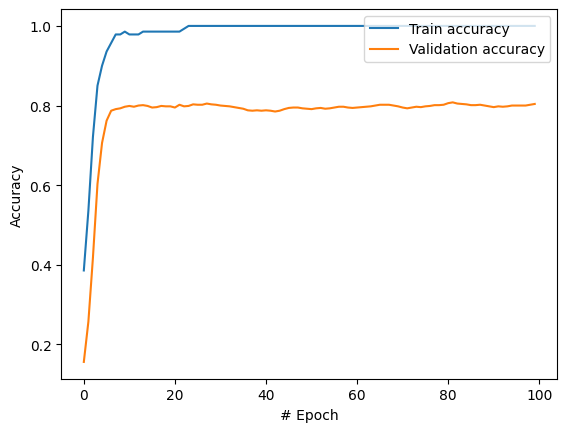

In [8]:

dataset = Planetoid(root='/tmp/Cora', name='Cora')

plot_dataset(dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train(data, plot=True)

In [13]:
dataset.num_node_features, dataset.num_classes

(1433, 7)

In [17]:
dataset[0].x.size(), dataset[0].edge_index.size()

(torch.Size([2708, 1433]), torch.Size([2, 10556]))

In [20]:
dataset[0].size()

(2708, 2708)

In [ ]:
dataset[0]